(-62.255, -62.135, 16.66, 16.84)
{'lat': 16.7106, 'lon': -62.17747, 'elev': 1000.0}
[INV] Networks: 1  Stations: 48  Channels: 77
[INFO] Grid loaded from /Users/glennthompson/Dropbox/MASTER_GRID_MONTSERRAT.pkl
[GRID] 831x1051 nodes (873381 total)  spacing=10.0 m  [mask: 59905/873381 nodes kept (6.9%)]


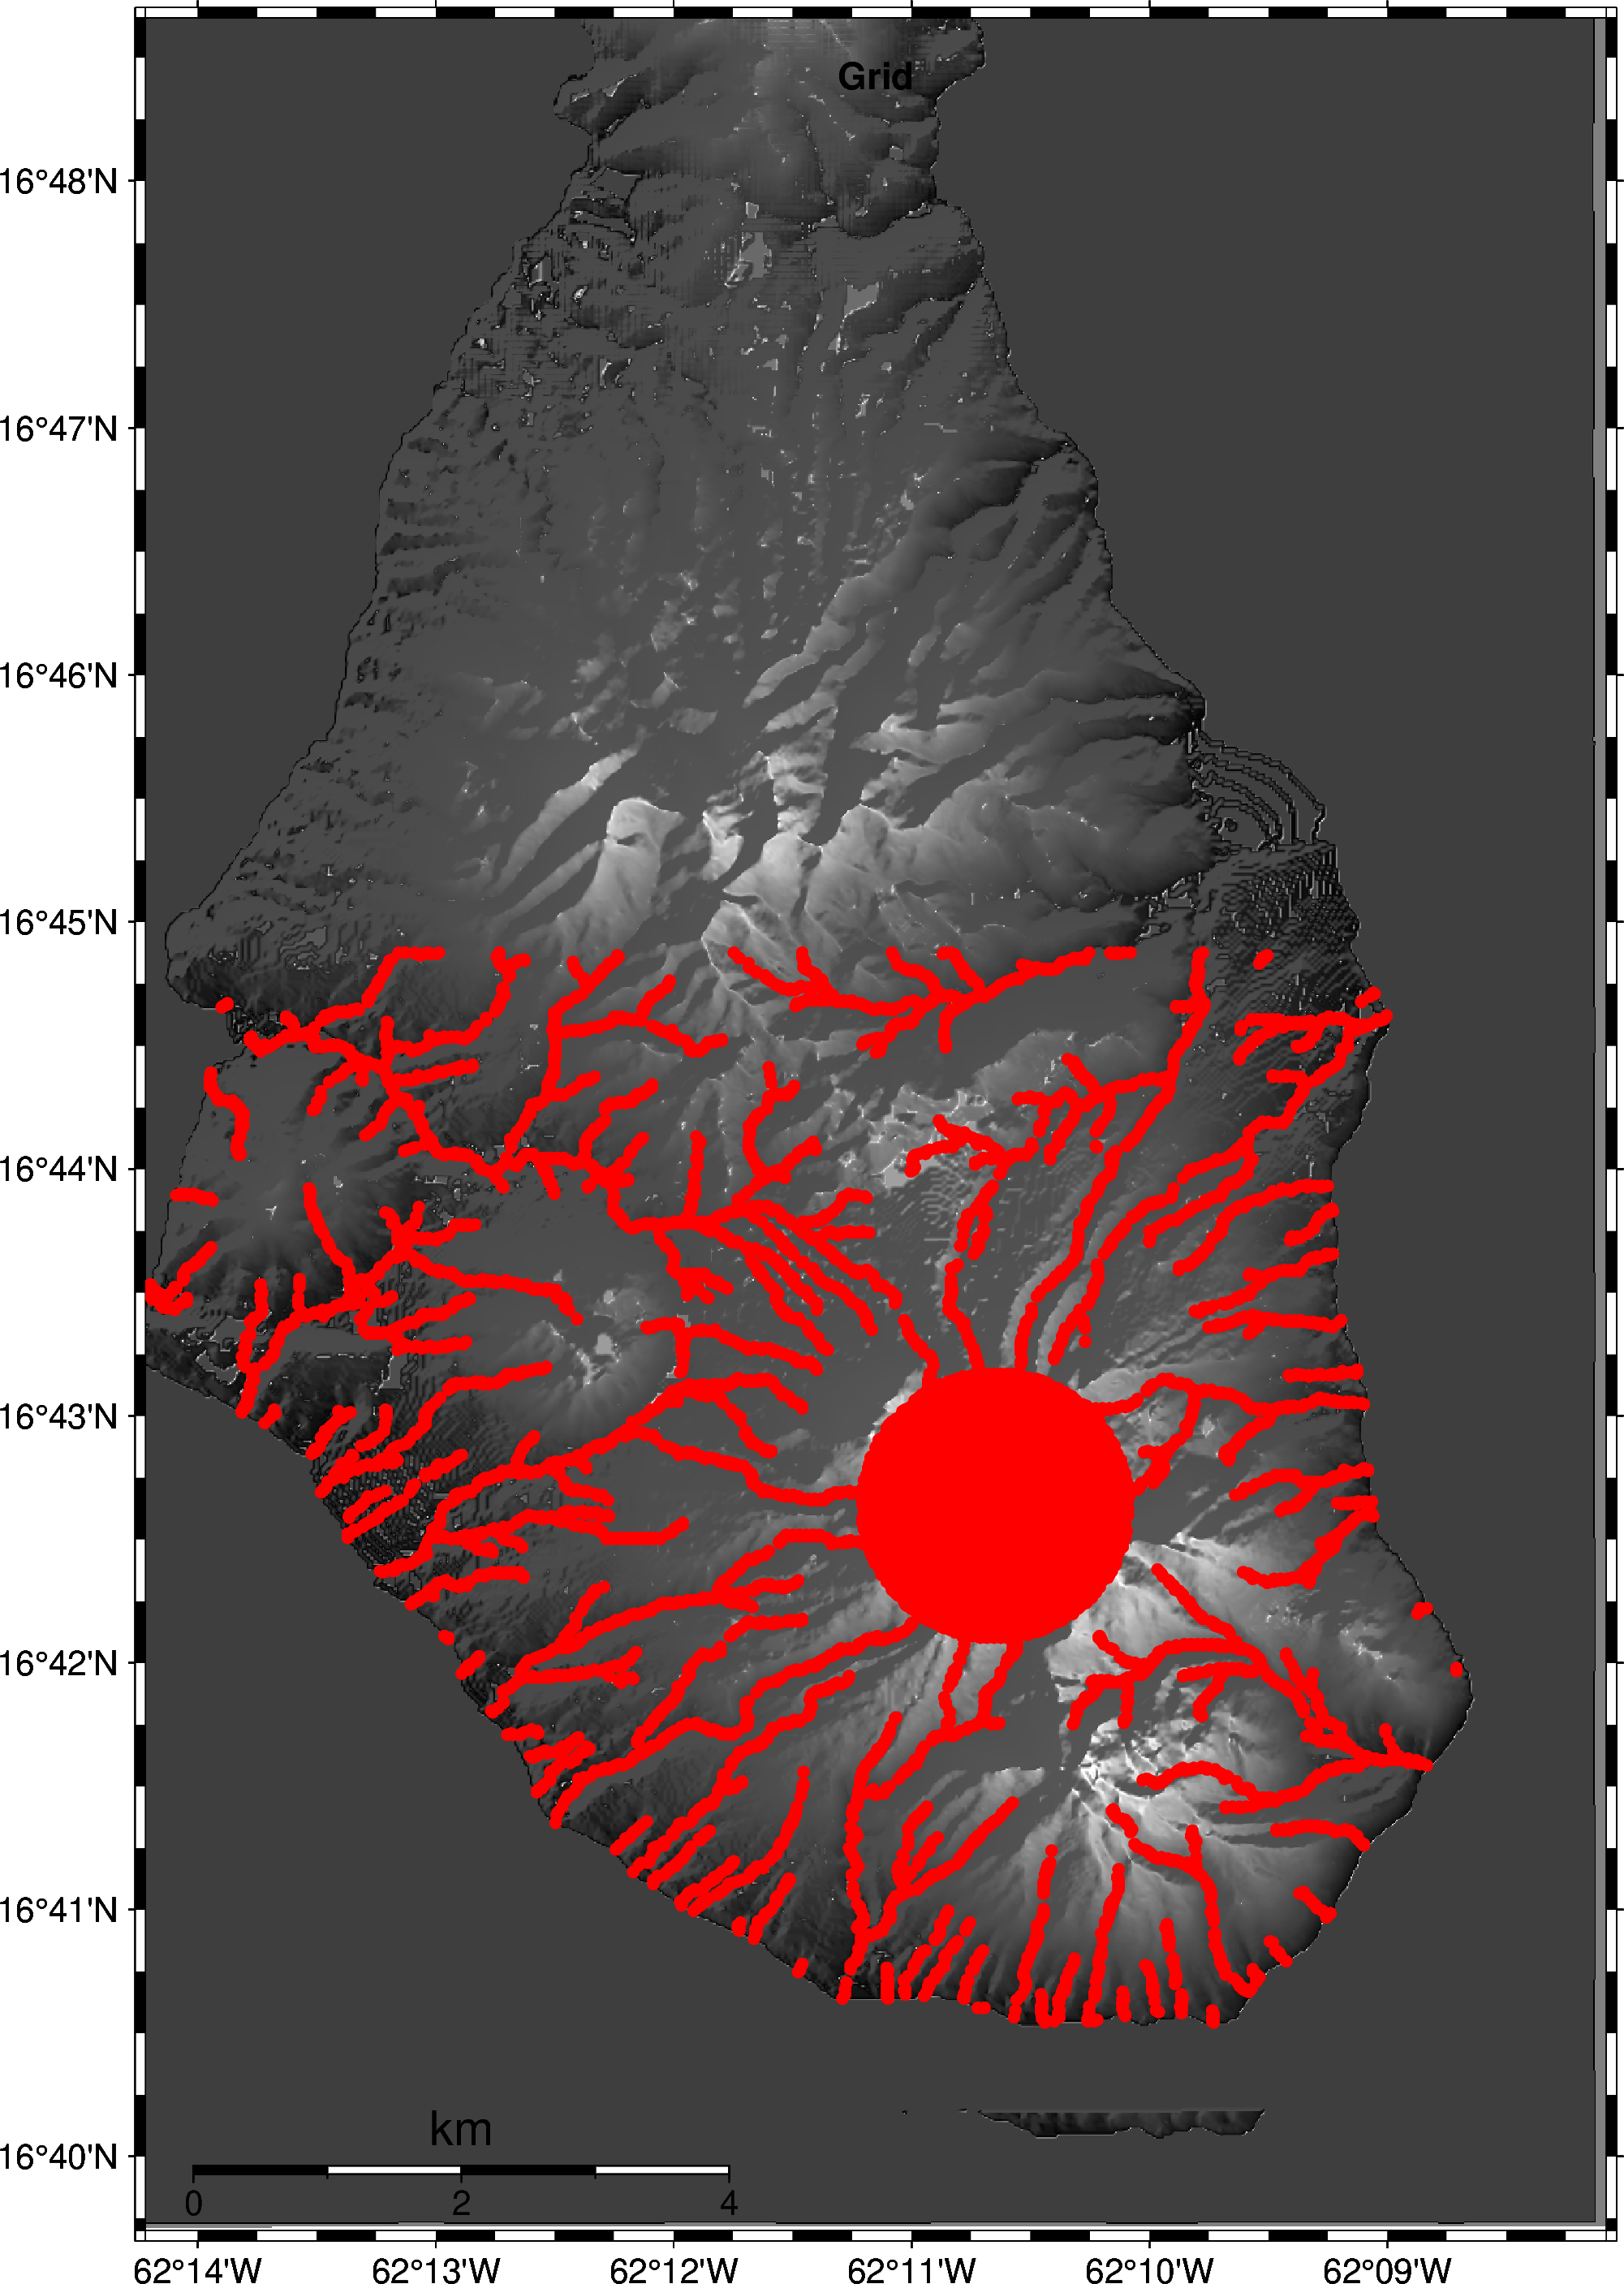

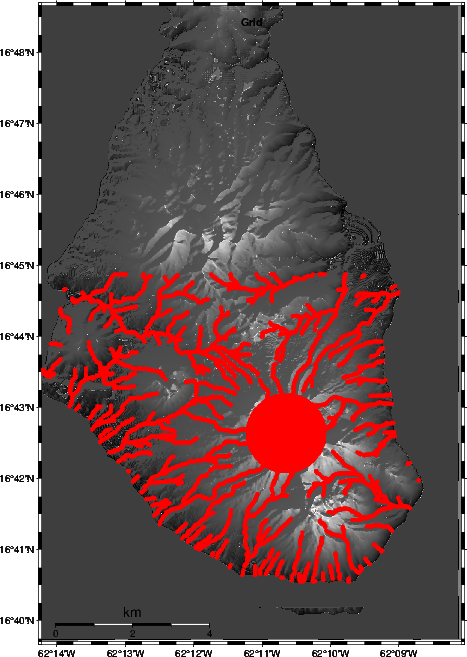

In [ ]:
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Any, List, Optional
from pathlib import Path
import numpy as np
import pandas as pd
from flovopy.asl.wrappers import run_single_event, find_event_files, build_asl_config, run_all_events
from flovopy.processing.sam import VSAM 
from obspy import read_inventory

# Base project directories
PROJECTDIR = "/Users/GlennThompson/Dropbox/BRIEFCASE/SSADenver"
LOCALPROJECTDIR = "/Users/GlennThompson/work/PROJECTS/SSADenver_local"
OUTPUT_DIR = f"{LOCALPROJECTDIR}/asl_notebooks"
INVENTORY_XML = f"/Users/glennthompson/Dropbox/MV_Seismic_and_GPS_stations.xml"
DEM_DEFAULT = Path("/Users/glennthompson/Dropbox/MONTSERRAT_DEM_WGS84_MASTER.tif")

# I/O
INPUT_DIR = f"{PROJECTDIR}/ASL_inputs/biggest_pdc_events"
DIST_MODE = "3d"        # include elevation\
GLOBAL_CACHE = f"{PROJECTDIR}/asl_global_cache"
OUTPUT_DIR = GLOBAL_CACHE

# Montserrat default region (lon_min, lon_max, lat_min, lat_max)
from flovopy.core.mvo import REGION_DEFAULT, dome_location
print(REGION_DEFAULT)
print(dome_location)

# Load inventory once
INV = read_inventory(INVENTORY_XML)
print(f"[INV] Networks: {len(INV)}  Stations: {sum(len(n) for n in INV)}  Channels: {sum(len(sta) for net in INV for sta in net)}")

GLOBAL_CACHE: Optional[str] = f"{PROJECTDIR}/asl_global_cache"
GRIDFILE_DEFAULT = "/Users/glennthompson/Dropbox/MASTER_GRID_MONTSERRAT.pkl"

from flovopy.asl.grid import Grid
gridobj = Grid.load(GRIDFILE_DEFAULT)
print(gridobj)
gridobj.plot(show=True, force_all_nodes=True, scale=5.0);



# Set up parameters that will be inherited to plot background topo maps, on top of which other maps will be created

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


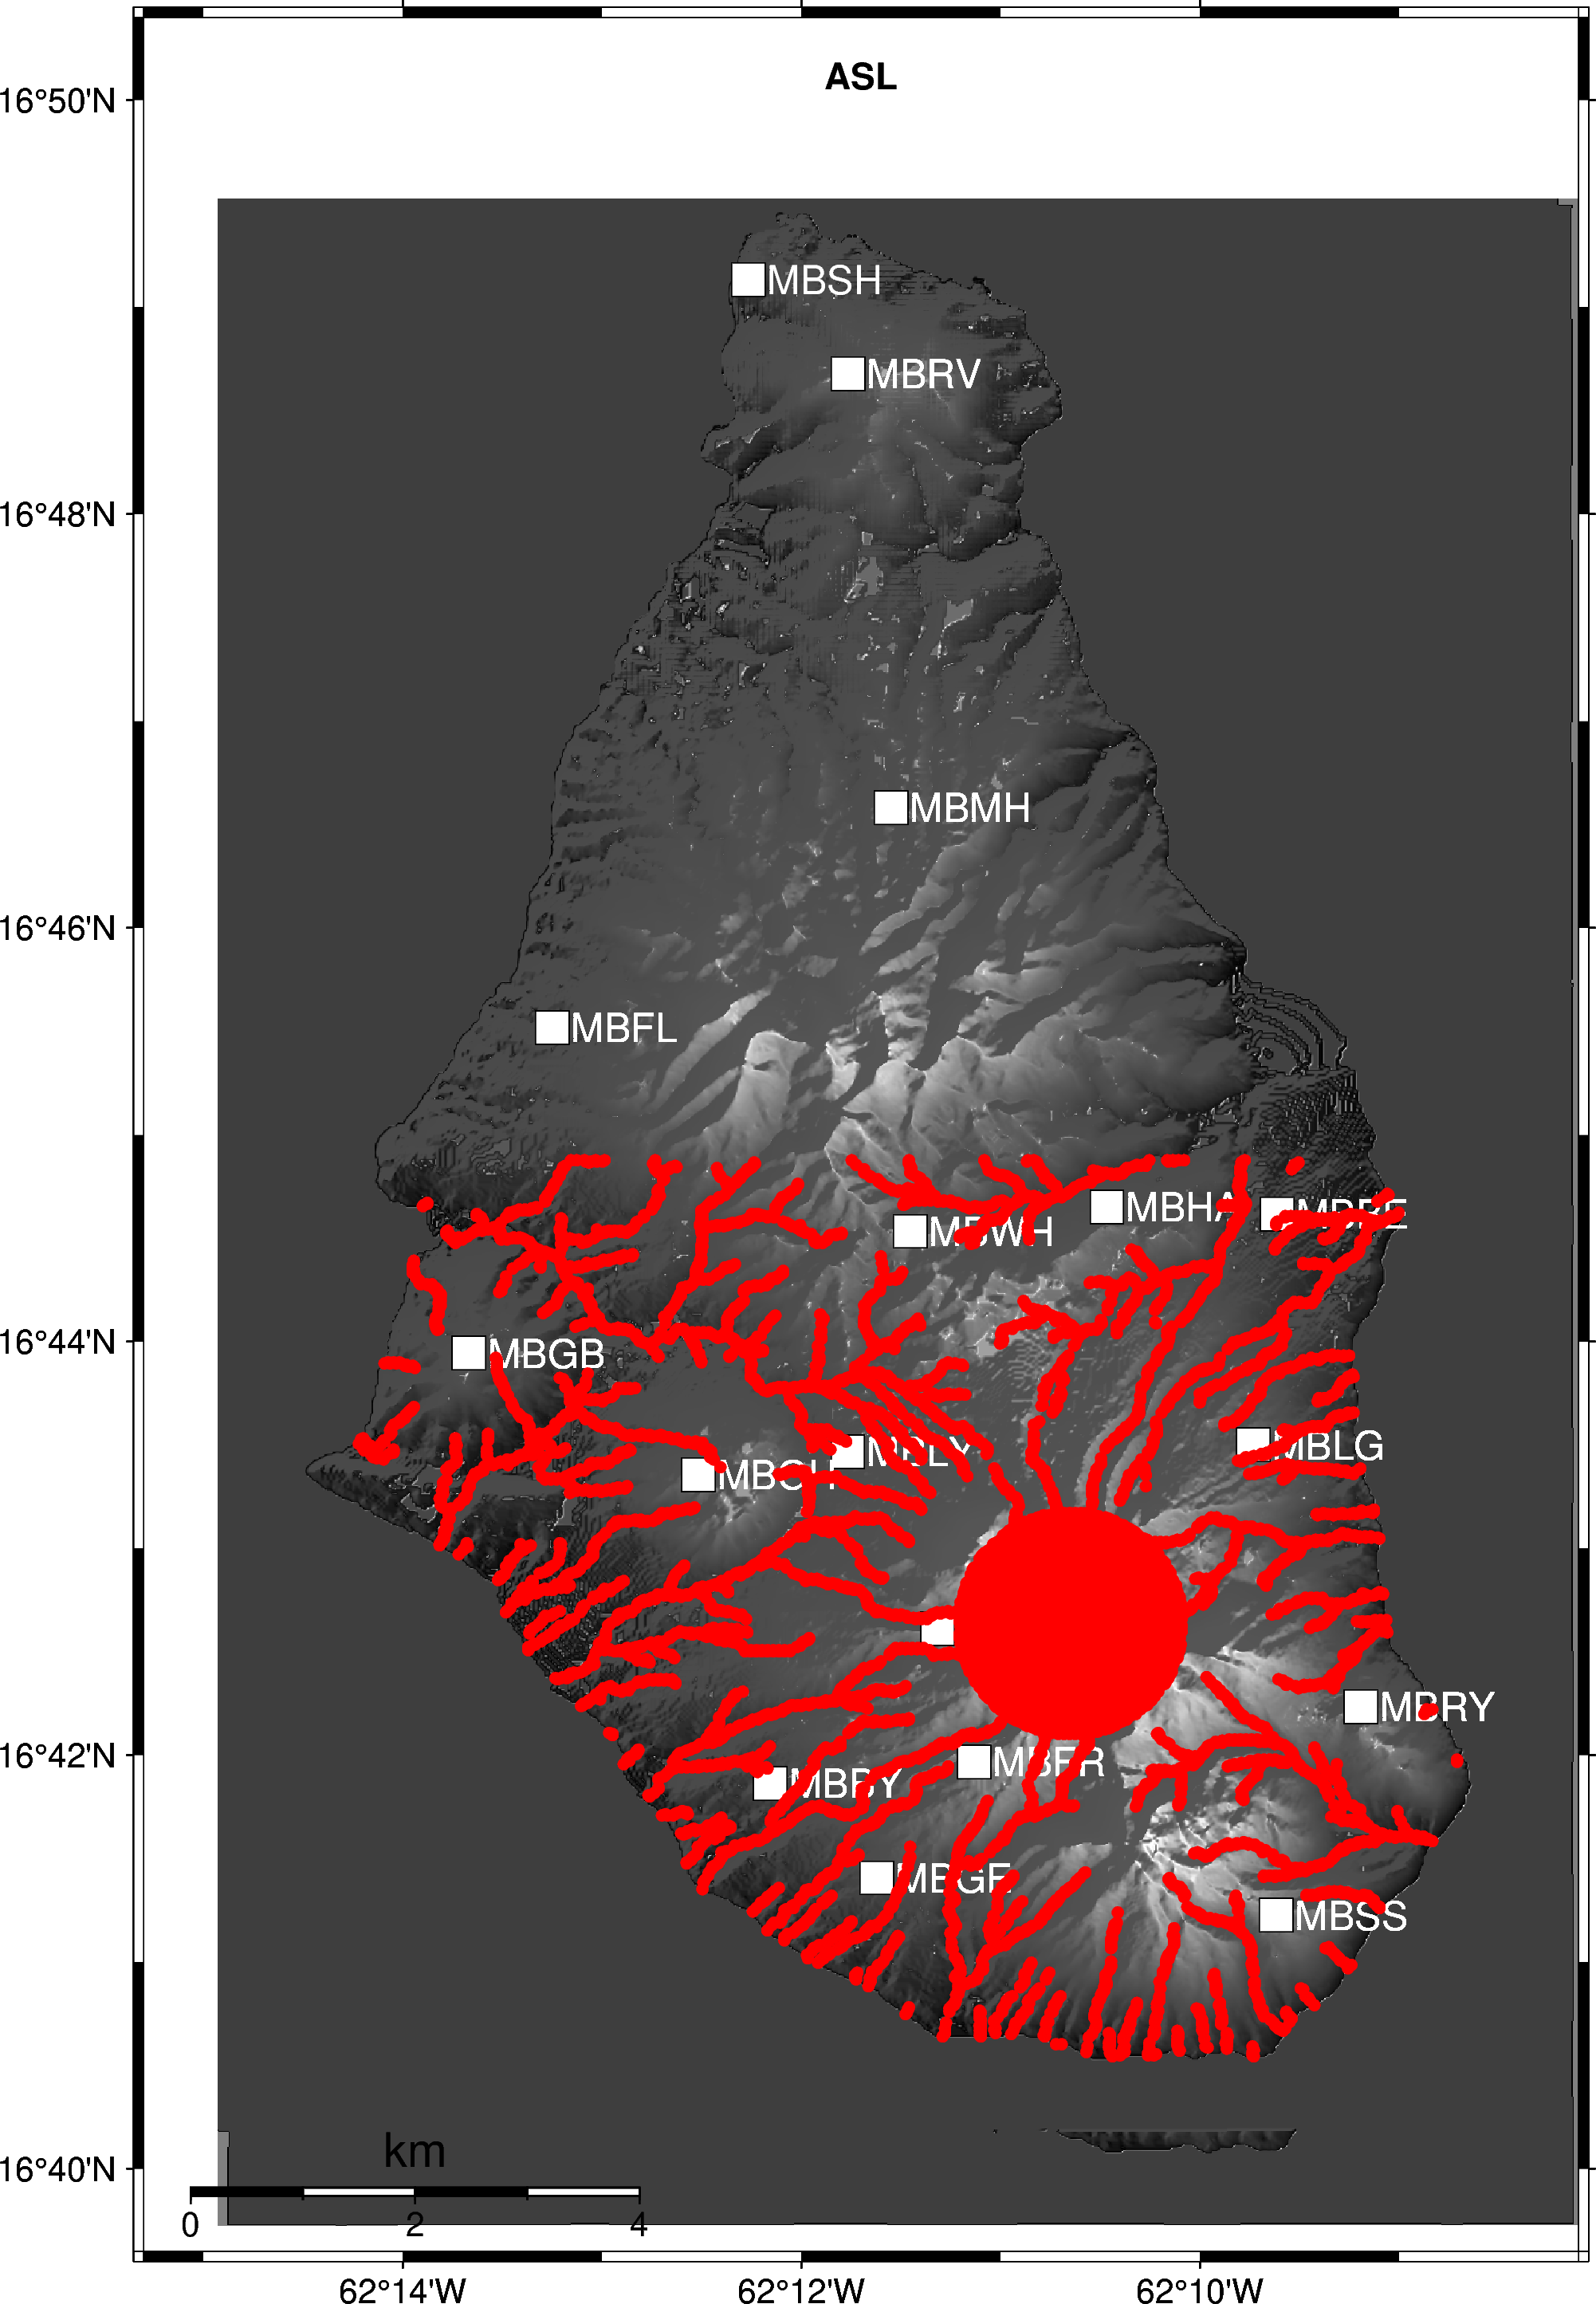

In [5]:
topo_kw = {
    "inv": INV,
    "add_labels": True,
    "cmap": "gray",
    "region": REGION_DEFAULT,
    "dem_tif": DEM_DEFAULT,  # basemap shading from your GeoTIFF - but does not actually seem to use this unless topo_color=True and cmap=None
    "title": "ASL",
    "frame": True,
    "dome_location": dome_location,
}
gridobj.plot(show=True, force_all_nodes=True, scale=5.0, topo_map_kwargs=topo_kw);

# Set up ASL and physics parameters

In [6]:
# ASL parameters
PEAKF = 8.0
METRIC = "VT"
WINDOW_SECONDS = 5
NODE_SPACING_M = 50
MIN_STATIONS = 5
REFINE_SECTOR = False   # enable triangular dome-to-sea refinement

# Physics / attenuation
WAVE_KIND = "surface"   # surface waves
DIST_MODE = "3d"        # include elevation
SPEED = 1.5             # km/s
Q = 100
MISFIT_ENGINE = "l2"

# Create a light configuration to drive the run
Arguably all of these things should be set within the asl_config dictionary directly, rather than stored under asl['config'].sweep_or_cfg as they are in the next cell.
This workaround was developed only because when running run_all_events(), we were constructing a sweep parameter, that only changed these particular variables.

In [ ]:
# --- Lightweight config object expected by run_single_event() (cell 2) ---
@dataclass
class LocalConfig:
    grid_kind: str = "regular"     # 'regular' or 'streams'
    wave_kind: str = "surface"     # 'surface' or 'body'
    dist_mode: str = "3d"          # '2d' or '3d'
    speed: float = 1.5             # km/s
    Q: int = 100
    misfit_engine: str = "l2"      # e.g. 'l2', 'huber'
    label: str = "nb_run"

    def tag(self) -> str:
        return f"{self.label}__G_{self.grid_kind}__W_{self.wave_kind}__D_{self.dist_mode}__V_{self.speed:g}__Q_{self.Q}__M_{self.misfit_engine}"
    
cfg = LocalConfig(
    wave_kind=WAVE_KIND,
    dist_mode=DIST_MODE,
    speed=SPEED,
    Q=Q,
    misfit_engine=MISFIT_ENGINE,
    label="notebook_run",
)
cfg.tag()
print(cfg)

# Build the asl_config dictionary, which will be inherited by downstream functions
This describes the config above, the station metdata, the grid, etc.

In [ ]:
asl_config = build_asl_config(
    sweep_or_cfg=cfg,
    inventory_xml=str(INVENTORY_XML),
    output_base=str(OUTPUT_DIR),
    peakf=PEAKF,
    gridobj=gridobj,
    sam_class=VSAM,
    sam_metric=METRIC,
    window_seconds=WINDOW_SECONDS,
    min_stations=MIN_STATIONS,
    global_cache=GLOBAL_CACHE,
    debug=True,
)

print(asl_config)

#  stash the whole asl_config?

In [ ]:
MAX_EVENTS = 1

input_dir = Path(INPUT_DIR)
#event_files = list(find_event_files(str(input_dir)))
event_files = list(find_event_files(Path(INPUT_DIR)))
print(f"Found {len(event_files)} event files.")
if MAX_EVENTS is not None:
    event_files = event_files[:MAX_EVENTS]
    print(f"Limiting to {len(event_files)} files.")
#event_files[:5]
for f in event_files:
    print(f)

# Run events from last cell, one event at a time, to check it works

In [ ]:
# --- Run ASL per event (cell 6) ---
summaries: List[Dict[str, Any]] = []

for i, ev in enumerate(event_files, 1):
    print(f"[{i}/{len(event_files)}] {ev}")
    result = run_single_event(
        mseed_file=str(ev),
        asl_config=asl_config,
        refine_sector=REFINE_SECTOR,
        station_gains_df=None,
        topo_kw=topo_kw,
        debug=True,
    )
    summaries.append(result)

# Summarize
df = pd.DataFrame(summaries)
display(df)

summary_csv = Path(OUTPUT_DIR) / f"{cfg.tag()}__summary.csv"
df.to_csv(summary_csv, index=False)
print(f"Summary saved to: {summary_csv}")

if not df.empty:
    n_ok = int((~df.get("error").notna()).sum()) if "error" in df.columns else len(df)
    print(f"Success: {n_ok}/{len(df)}")

# Run all events efficiently

In [ ]:
run_all_events(
    input_dir=INPUT_DIR,
    station_gains_df = None,
    asl_config=asl_config,
    refine_sector=REFINE_SECTOR,
    topo_kw=topo_kw,
    debug=True,
    max_events=999999,
    use_multiprocessing=True,
    workers=4,
)
 